# Instructions

As in the previous assignment, youl'll be using PyTorch instead of EDF. This assignment will focus on generative modelling, and you'll implement and train a VAE and a GAN.

It is highly suggested to use google colab and run the notebook on a GPU node.
Check https://colab.research.google.com/ and look for tutorials online on how to use it. To use a GPU go to Runtime -> Change runtime type and select GPU.

In [1]:
import torch, math, copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from scipy.stats import kde
import matplotlib.pyplot as plt
import random as rand
import torch.distributions as distr
from torch.distributions.multivariate_normal import MultivariateNormal

We'll start by coding up a toy problem and seeing how a VAE and a GAN behave on it. Consider the following stochastic process:
$$ \mu_x \sim U(\{1,2,3\})$$
$$ \mu_y \sim U(\{1,2,3\})$$
$$ s \sim \mathcal N \left([\mu_x, \mu_y], \frac{1}{100}I \right)$$
where $I$ is the $2 \times 2$ identity matrix.

Implement the function in the next cell such that it returns $n$ samples distributed as $s$ from the above process. The returned object should be a $n \times 2$ PyTorch tensor.

In [ ]:

def sample(n):

    means = torch.randint(1, 4, (2,))
    means=means.type(torch.FloatTensor)
    SDs = torch.eye(2)/100

    mvn = MultivariateNormal(means, SDs)
    s = mvn.sample()

    #print(s)

    for i in range(1, n):

        means = torch.randint(1, 4, (2,))
        means=means.type(torch.FloatTensor)
        SDs = torch.eye(2)/100

        mvn = MultivariateNormal(means, SDs)
        temp = mvn.sample()

        s = torch.cat((s, temp), dim= 0)
        #print(temp)

    s = torch.reshape(s, (n,2))

    return s

x = sample(10)
print(x)
print(x.size())
print(torch.mean(x, dim=0))

tensor([[1.0637, 0.9378],
        [1.0076, 2.8328],
        [3.0497, 0.9244],
        [1.7934, 3.0665],
        [3.0686, 3.0119],
        [2.0549, 0.9718],
        [2.7724, 1.1572],
        [3.0156, 2.0691],
        [0.9867, 3.0226],
        [1.9538, 0.9175]])
torch.Size([10, 2])
tensor([2.0766, 1.8912])


In [ ]:
def oldsample(n, latent_dim):
    s = torch.randn(n, latent_dim, 1, 1)

    return s

x = oldsample(32, 2)
print(x.size())



torch.Size([32, 2, 1, 1])


In [ ]:
def oldsample(n):
    means = torch.zeros(2)
    var = torch.ones(2)

    mvn = MultivariateNormal(means, scale_tril=torch.diag(var))

    s = mvn.sample(sample_shape = (n,3,3))

    return s

x = oldsample(10)
print(x.size())
#print(torch.mean(x))
#print(torch.exp(x))
#print(x.size(dim=0))
#print(x -x )


#print(torch.tensor([0,0]))
#print(torch.mean(x))
#print(np.mean(x[1,:]))
#print(np.std(x[0,:]))
#print(np.std(x[1,:]))





torch.Size([10, 3, 3, 2])


Now we'll sample 1000 points and see how they are distributed.

In [ ]:
def plot_density(data):
    data = data.numpy()
    nbins = 50
    x, y = data.T
    k = kde.gaussian_kde(data.T)
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)

    plt.tight_layout()
    plt.show()
    plt.clf()

torch.Size([5000, 2])
tensor([2.0037, 2.0105])
tensor([0.6818, 0.6857])


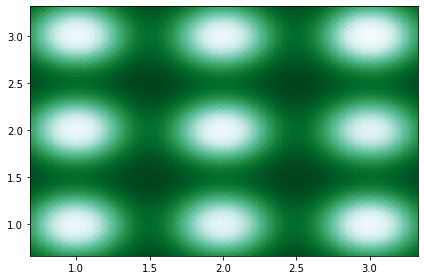

<Figure size 432x288 with 0 Axes>

In [ ]:
data = sample(5000)
print(data.size())
print(torch.mean(data, dim = 0))
print(torch.var(data, dim=0))
plot_density(data)

## VAE on a Toy Problem

Recall that when training a VAE we're concerned with the following problem:

$$\min_{\phi} \,\ \mathbb E_{x \sim Pop, z \sim P_\phi(z|x)} \left[ \ln \frac{P_\phi(z|x)}{P(z)} - \ln P_\phi(x|z) \right] \,.$$

We'll model $P_\phi(z|x)$ with an encoder and $P_\phi(x|z)$ with a decoder as follows:
$$P_\phi(z|x) = \mathcal N \left(\mu_{\phi,z}(x), \Sigma_{\phi,z}(x) \right)$$
$$P_\phi(x|z) = \mathcal N \left( \mu_{\phi,x}(z), \sigma^2 I \right) \,,$$
where $\mu_{\phi,z}, \Sigma_{\phi,z}, \mu_{\phi,x}$ are neural networks, and $\Sigma_{\phi,z}(x)$ is diagonal.

Moreover, let $P(z)$ (the prior over $z$) to be $\mathcal N(0, I)$.


**<span style="color:blue">
    For the above distributions, what is $\ln P_\phi(x|z)$ as a function of $x, z, \mu_{\phi,x}$, and $\sigma$?
</span>**

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (BEGIN) -------------------------------------------------------------------------------
</span>**

$\ln P_{\phi}(x|z) = -\frac{d}{2}(\ln 2 + \ln \pi + 2\ln \sigma) -\frac{||x-\mu_{\phi, x}(z)||^2}{2\sigma^2}$

$d$ is the dimension of the sample (2 for the toy problem).

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (END) -------------------------------------------------------------------------------
</span>**

**<span style="color:blue">
    For the above distributions, what is $\ln \frac{P_\phi(z|x)}{P(z)}$ as a function of $x, z, \mu_{\phi,z}, \Sigma_{\phi,z}$?
</span>**

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (BEGIN) -------------------------------------------------------------------------------
</span>**

$-\frac{1}{2}\ln \text{det}(\Sigma_{\phi , z} (x)) -\frac{||\Sigma_{\phi , z} (x)^{-1/2}(z-\mu_{\phi,z} (x))||^2}{2} + \frac{||z||^2}{2}$

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (END) -------------------------------------------------------------------------------
</span>**

We are almost ready to set up a VAE network in PyTorch and train it. The following cell has an incomplete implementation of a VAE. The encoder and decoder networks are already defined (note that the encoder outputs $\log \Sigma$ instead of $\Sigma$, which is standard practice since otherwise we have to guarantee that the covariance matrix is non-negative). latent_dim is the dimensionality of the latent variable $z$.

Complete the implementations of encode, sample, and decode.
The encode method receives samples $x$ and has to return the mean vector $\mu_z(x)$ and the element-wise log of the diagonal of $\Sigma_z(x)$. The self.encoder network already maps $x$ to a 50-dim vector, and the self.mu, self.logvar modules can be used to map this 50-dim vector to the mean vector and the log diag of the covariance matrix.

The sample method receives mu and logvar (the outputs of encode) and has to return samples from the corresponding Gaussian distribution. Here we typically employ the reparameterization trick, where we can draw a sample $s \sim \mathcal N(\mu, \sigma)$ by doing $s = \mu + \sigma \cdot \epsilon, \epsilon \sim \mathcal N(0, 1)$, which yields well-defined gradients that autograd takes care of computing. Like in the original VAE paper, sample a single $s$ for each input.

Finally, the decode method takes $z$ as input and should return $\mu_x(z)$. You should use the self.decodet module for this.

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(2, 50), ## in features, out features
            nn.ReLU(),
            nn.Linear(50, 50), ## in features, out features
            nn.ReLU()
        )

        self.mu = nn.Linear(50, latent_dim)
        self.logvar = nn.Linear(50, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 2) ## in features, out features
        )

    def encode(self, x):
        # implementation goes here
        encoded = self.encoder(x)

        mu = self.mu(encoded)

        logvar = self.logvar(encoded)

        return mu, logvar
    
    def sample(self, mu, logvar):
        # implementation goes here
  
        loc = torch.zeros(self.latent_dim)
        scale = torch.ones(self.latent_dim)
        mvn = MultivariateNormal(loc, scale_tril=torch.diag(scale))

        z = mvn.sample(sample_shape=(128,)).cuda() ##128 samples

        #print("z size: ", z.size())
        z = z*torch.sqrt(torch.exp(logvar)) + mu

        #print("z size: ", z.size())
        
        return z
    
    def decode(self, z):
        # implementation goes here
        out = self.decoder(z)

        #print( "out size before mean: ",out.size())

        #print( "out size after mean: ",out.size())
        return out
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        out = self.decode(z)
        return mu, logvar, out
    
    def generate(self, n):
        z = torch.randn(n, self.latent_dim).cuda()
        samples = self.decode(z) #this is the original line
        #samples = self.decoder(z) #this is the line I changed it to
        return samples

Note that the previous VAE objective can be written as

$$\min_{\phi} \,\ \mathbb E_{x \sim Pop} \left[ D_{KL}(P_\phi(z|x) || P(z)) + \mathbb E_{z \sim P_\phi(z|x)} \left[ -\ln P_\phi(x|z) \right] \right] \,$$

The first term requires computation of KL divergence between two multivariate Gaussian distributions, which has a closed form solution. The second term requires sampling noise. As in the case of the original VAE paper, sample a single $z$ for every $x$ in the forward pass in order to compute this second quantity.

Now, implement the loss of the VAE by deriving the closed-form expression for the KL divergence as well as using the expression for $\ln P_\phi(x|z)$ you derived previously. The recon_loss term should have the factor corresponding to $P_\phi(x|z)$, while kld_loss should have the KL divergence term.

In your derivation $\sigma$ hopefully showed up as a weight between the two terms. Here we'll use the standard beta-VAE notation and apply a weight beta on the KL divergence term instead.

In [ ]:
def loss(x, out, mu, logvar, beta):

    #print("x size: ", x.size())
    #print("out size: ", out.size())
    #print("mu size: ", mu.size())
    #print("logvar size: ", logvar.size())

    recons_loss = torch.mean(1/2*(math.log(2) + math.log(math.pi) + (x-out)**2), dim=0)

    #print("recons_loss size: ", recons_loss.size())

    recons_loss = torch.sum(recons_loss, dim=0)

    #print("recons_loss size: ", recons_loss.size())

    Sigma = torch.exp(logvar)

    kld_loss = torch.mean(1/2*(Sigma + mu**2 - logvar - 1), dim=0)

    #print("kld_loss size: ", kld_loss.size())

    kld_loss = torch.sum(kld_loss, dim=0)

    #print("kld_loss size: ", kld_loss.size())

    loss = recons_loss + beta * kld_loss
    
    return recons_loss, kld_loss, loss

We can then train the VAE on the toy problem and see how it performs.
Try different values of beta until you find one that yields good results.

In [ ]:
vae = VAE(100).cuda()
opt = torch.optim.Adam(vae.parameters(), lr=5e-4)

Plot  1 /20


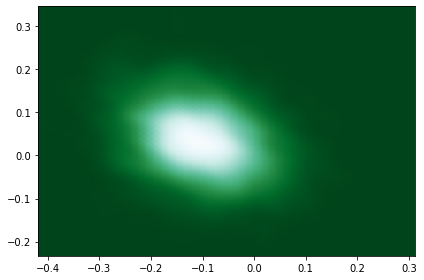

Plot  2 /20


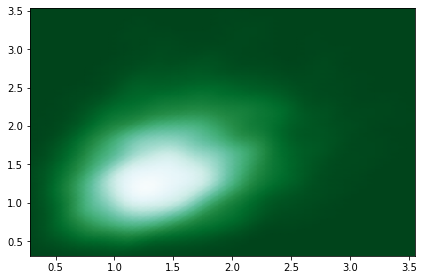

Plot  3 /20


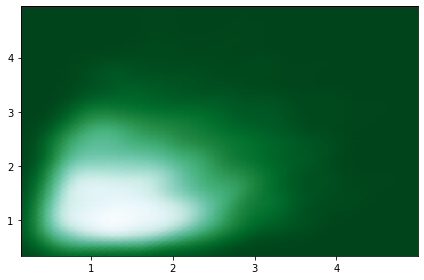

Plot  4 /20


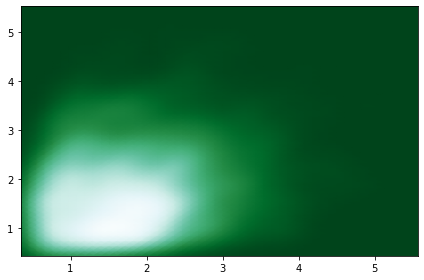

Plot  5 /20


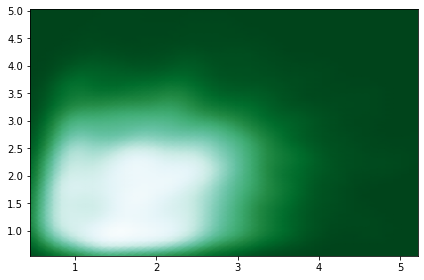

Plot  6 /20


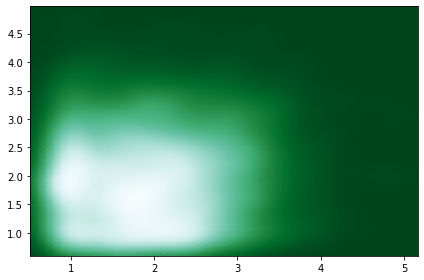

Plot  7 /20


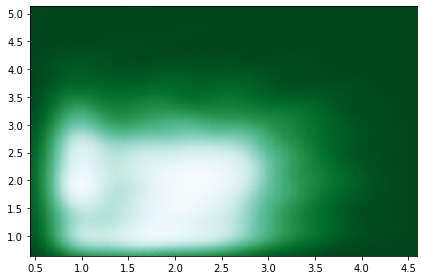

Plot  8 /20


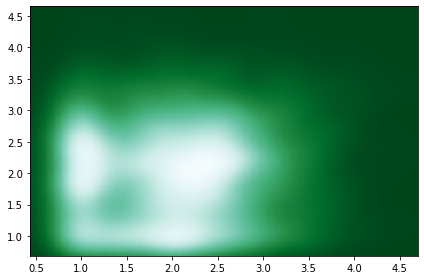

Plot  9 /20


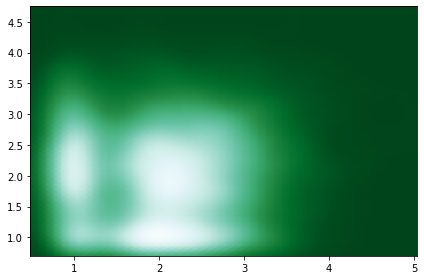

Plot  10 /20


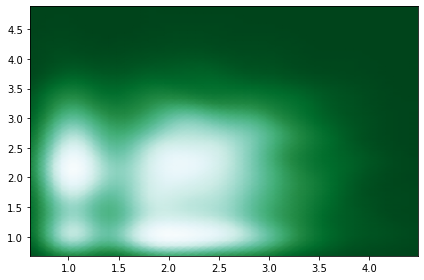

Plot  11 /20


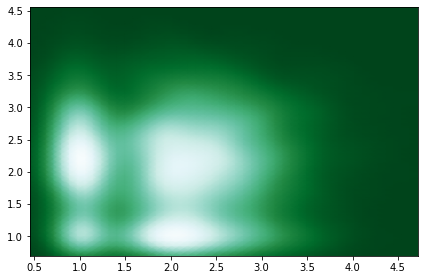

Plot  12 /20


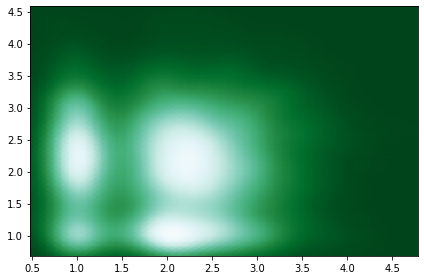

Plot  13 /20


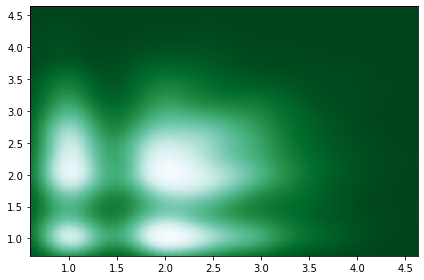

Plot  14 /20


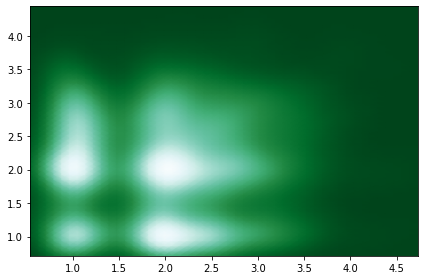

Plot  15 /20


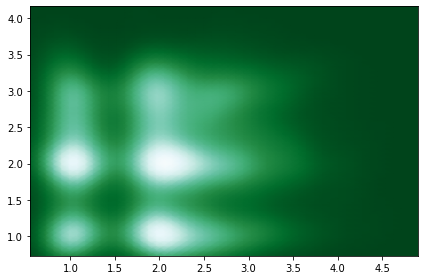

Plot  16 /20


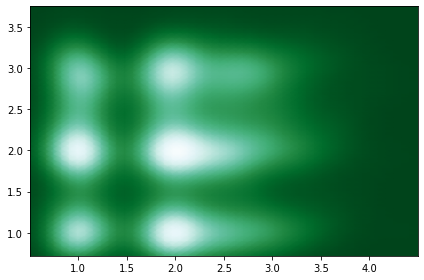

Plot  17 /20


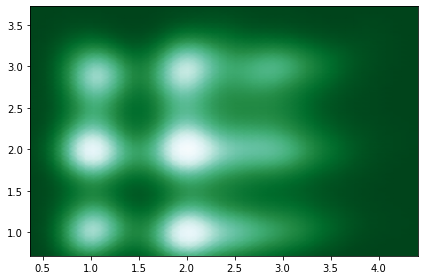

Plot  18 /20


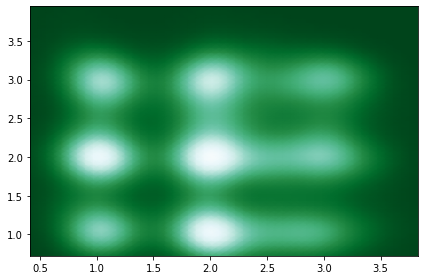

Plot  19 /20


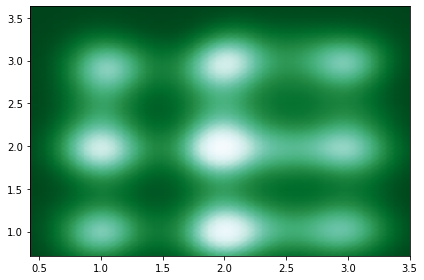

Plot  20 /20


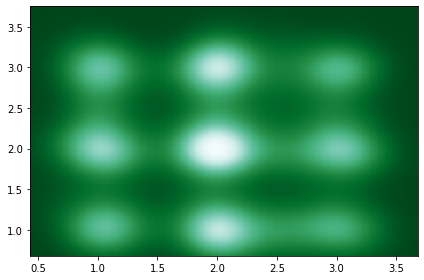

<Figure size 432x288 with 0 Axes>

In [ ]:
beta = 0.01
k=1
for i in range(20000):
    s = sample(128).cuda()
    mu, logvar, out = vae(s)
    rl, kl, l = loss(s, out, mu, logvar, beta)
    opt.zero_grad()
    l.backward()
    opt.step()
    if i % 1000 == 0:
        data = vae.generate(5000)
        print("Plot ", k, "/20")
        k= k+1
        plot_density(data.cpu().data)

**<span style="color:blue">
    How does beta affect the performance of the VAE? Show or discuss what tradeoff beta controls, and how this can be observed from the above plots and/or any additional plots.
</span>**

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (BEGIN) -------------------------------------------------------------------------------
</span>**

The loss is $\beta (\text{kld_loss}) + \text{recons_loss}$. When the kld_loss term is small, that means that $P(z|x)$ is close to a $N(0,I)$ distribution, i.e., closer to being isotropic with each component being conditionally indpendent. $P(x|z)$ on the other hand, is the reconstruction probability of the samples from the latent variables, and therefore relates to the accuracy of the generated samples. Therefore, $\beta$ controls the tradeoff of the ability of the latent variable in modeling $x$ and how close $P(z|x)$ is to being $N(0, I)$ and isotropic vs. the accuracy of the reconstructed samples.

$\beta = 0.01$: this seems to be the best setting I could achieve given how long this program takes to run and time constraints. The fakes resemble the actual data on a 3x3 grid with correct mean positions even more than with $\beta=0.1$. It seems that we may be able to get fairly close to the true distribution by tuning $\beta$. The fakes are however, more faint than the true distribution, which I think may be due to the data being more spread out around the true means than in the true simulated data.

$\beta=0.1$: the fakes resemble the actual data on a 3x3 grid with correct mean positions more than with $\beta=0.2$ but less than $\beta = 0.01$.

$\beta=0.2$: the fakes resemble the actual data on a 3x3 grid with correct mean positions rather than just one blob, however, it is still blurry and not quite as good as the GAN, with plenty of fakes in between the true mean nodes such that the nodes look "connected".

When $\beta$ is large, this means more emphasis is put on the generated data being normal and isotropic, since this is what the KLD term corresponds to. If $\beta$ is too large, the generated data may appear normal and isotropic, but not be accurate representations of the true data. When $\beta$ is small, this means more emphasis is put on reconstruction accuracy - if $\beta$ is too small, the data may have a strange shape that is not normal or isotropic.

$\beta$ = 0.5: The points seem to approach something that looks more rectangular as in the actual data, however, they still appear to be one blob that roughly appears normal. I think this means I need to decrease $\beta$ in order to put less emphasis on the data being normal and isotropic and more on the quality of reconstruction. Note that it takes awhile to run these trials and I still have remaining parts of the assignment to complete, so I may not be able to try a very wide range of $\beta$.

$\beta = 0.7$. The results are similar to $\beta =0.5$. I chose 0.7 because the variance of the data itself is around 0.7. Thus, this value of $\beta$ corresponds to if $\beta$ was 1 and the recons_loss term was multiplied by $\frac{1}{\sigma^2}$, the variance of the data.

$\beta = 5$: Elliptical plots centered around (2,2). May indicate that $\beta$ is too large.

================================================================================

Note: the comments below do not apply to this question anymore. They pertained to when I made a mistake in the calculation of the sample function, assuming all samples had the same mean. For the sake of grading these comments below do not need to be read.



Thus, when $\beta$ is 0 or smaller than 1 (I tried 0 or 0.01), the resulting density plots have a shape that is bent (an ellipse, not a perfect circle), and thus non-isotropic, meaning the components of z are not conditionally independent - there is less circular symmetry in the resulting distribution. The spread of the density plots also seems much smaller compared to large $\beta$, i.e., less variability in the generated samples of x. This makes sense, since from the loss formula, small beta corresponds to small variance in x. Also, the estimates of the means as judged by the density plots do not seem accurate. When I tried $\beta = 0.5$ though, the means seemed closer to reasonable values (integers), and the density plots were less bent and closer to a $N(0, I)$ distribution, although more jagged than $\beta = 1$.

However, when I increase beta to be larger than 1 (I tried 5 or 10), the resulting density plots display much more circular symmetry. In other words, they look much closer to a $N(0, I)$ Gaussian. This makes sense, since by increasing the importance of the kld_loss term forces it to be smaller, and $P(z|x)$ to be closer to a $N(0, I)$ distribution. Also, the spread of the density plots seems larger than for small $\beta$. This makes sense, because from the formula for the loss function, large $\beta$ corresponds to large variance in $x|z$. Thus, it is also hard to tell where the mean of the generated points is, so they may or may not be accurate.

When $\beta$ is close to 1, we see more circular symmetry similar to that of the $N(0,I)$ distribution. The spread in generated samples of x is now somewhere in between that of when $\beta$ is much larger or smaller than 1. Also, the estimated means seem much closer to the true means of x. I think $\beta = 1$ seems optimal for this problem, based off of these factors. Further, $\beta = 1$ corresponds to the variance of $x|z$ being 1, and this may be reasonable considering the true variance of x is 1. Therefore, by choosing $\beta$ to be far from 1, we may be minimizing a loss function that corresponds to something farther from $H(x) \leq H_{pri}(z) + H_{dec}(x|z) - H_{enc}(z|x)$.

References: 

    https://www.inference.vc/beta-vae/

    https://paperswithcode.com/method/beta-vae

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (END) -------------------------------------------------------------------------------
</span>**

## GAN

Recall the GAN objective
$$\min_\psi \max_\phi \,\ \mathbb E_{x \sim Pop}[ -\ln P_\psi(1 | x) ] + \mathbb E_{z \sim \mathcal N(0,1)} [- \ln P_\psi(0|G_\phi(z))  ] \,,$$
where $G_\phi$ is a network that maps gaussian noise $z \sim \mathcal N(0,1)$ to $G(z)$ with the same shape as $x$, and $P_\psi$ is modeled by another network (the discriminator) that maps real samples $x$ and 'fake' samples $G(z)$ to a distribution over $\{0,1\}$.

We will follow the common practice of adopting a different objective for the generator network $G$:
$$\min_\phi \,\ \mathbb E_{z \sim \mathcal N(0,1)} [- \ln P_\psi(1|G_\phi(z))  ] \,.$$

First, complete the implementation of the Generator module below. The forward method takes an integer $n$ as input and should return $n$ samples $G(z), z \sim \mathcal N(0, I)$, each with dimensionality 2. You should use the self.network module for the mapping $G$.

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.network = nn.Sequential(
            nn.Linear(latent_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def decode(self, input):
        out = self.network(input)
        return out

    def forward(self, n):
        means = torch.zeros(100)
        SDs = torch.ones(100)

        mvn = MultivariateNormal(means, scale_tril=torch.diag(SDs))

        z = mvn.sample(sample_shape=(n,)).cuda() # implementation goes here 

        samples = self.decode(z) # implementation goes here

        return samples

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )
    
    def forward(self, input):
        out = self.network(input)
        return out

In [ ]:
generator = Generator(100).cuda()
gopt = torch.optim.Adam(generator.parameters(), lr=5e-4, betas=(0.5, 0.999))
discriminator = Discriminator().cuda()
dopt = torch.optim.Adam(discriminator.parameters(), lr=5e-4, betas=(0.5, 0.999))
criterion = torch.nn.BCEWithLogitsLoss()

Now, you'll implement the training procedure for GANs. In each iteration of the for loop below we'll update the parameters of the generator and then update the discriminator.

Fill up the missing code below. You should rely on the objective given previously to define the loss of the generator and the discriminator (both the function, the data inputs, and the target labels).

In [ ]:
def loss(out):

    l = -1*torch.log(out)
    l = torch.mean(l) #generator loss
    
    return l

Plot  1 /20


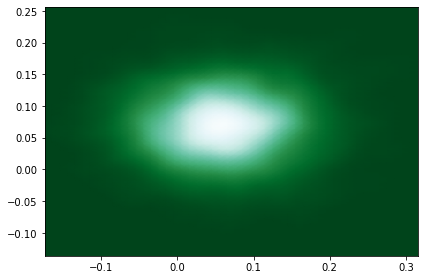

Plot  2 /20


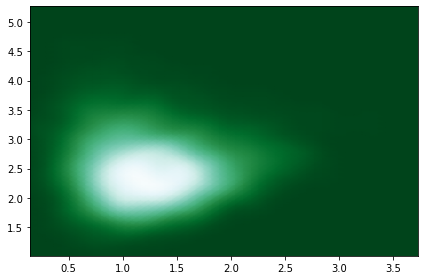

Plot  3 /20


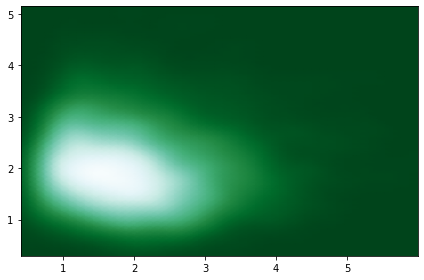

Plot  4 /20


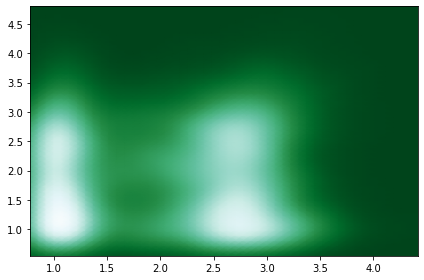

Plot  5 /20


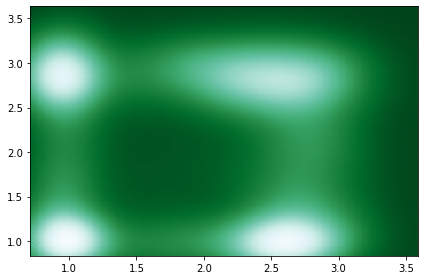

Plot  6 /20


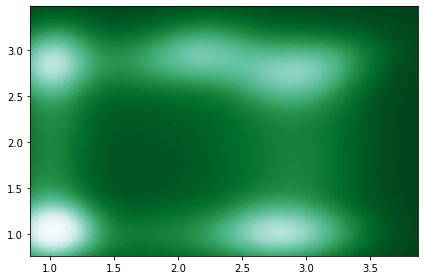

Plot  7 /20


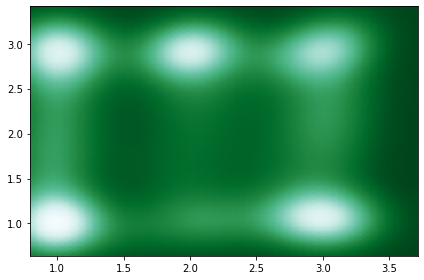

Plot  8 /20


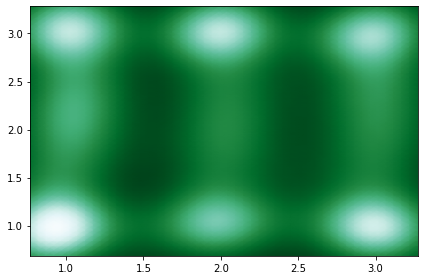

Plot  9 /20


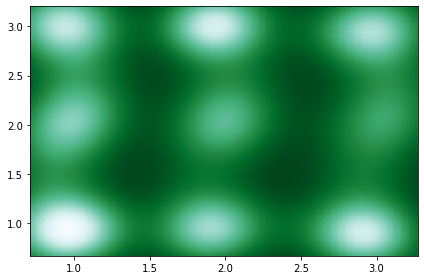

Plot  10 /20


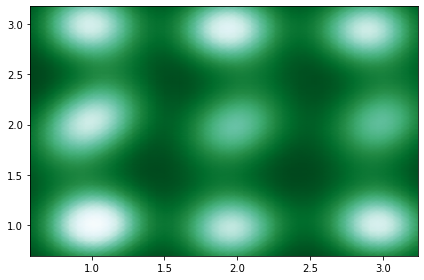

Plot  11 /20


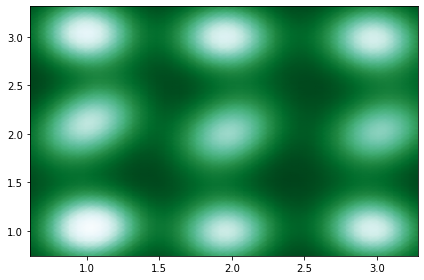

Plot  12 /20


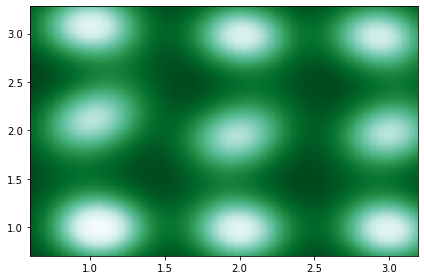

Plot  13 /20


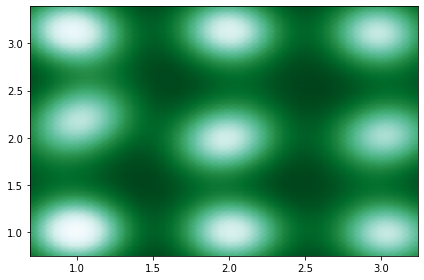

Plot  14 /20


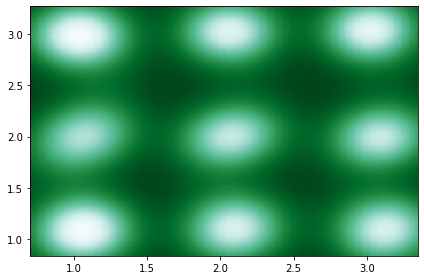

Plot  15 /20


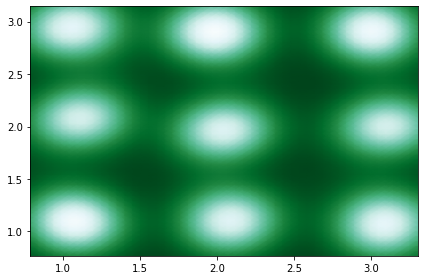

Plot  16 /20


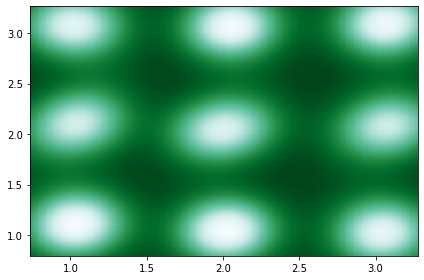

Plot  17 /20


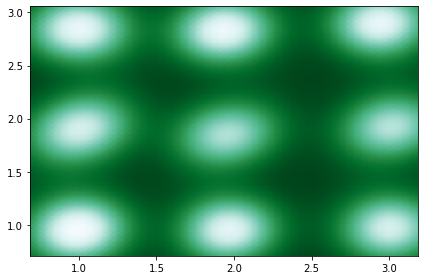

Plot  18 /20


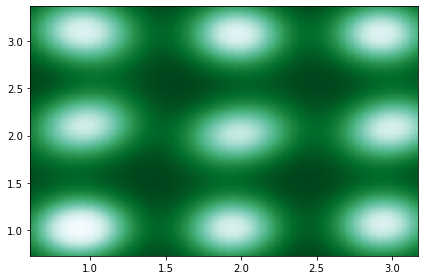

Plot  19 /20


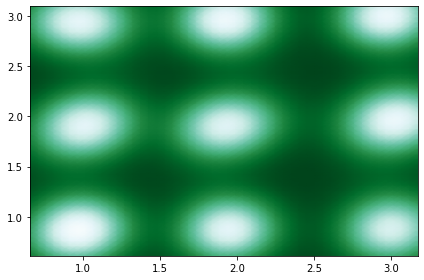

Plot  20 /20


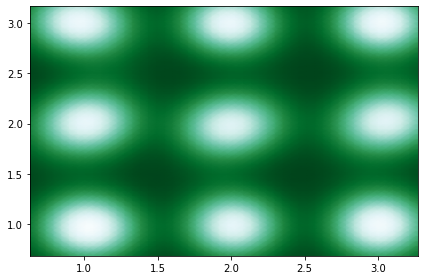

In [ ]:
k=1

for i in range(20000):
    # Train G
    # implementation goes here

    realsamples = sample(128).cuda()
    fakesamples = generator(128).cuda()

    #get discriminator values
    p = discriminator(realsamples)
    q = discriminator(fakesamples)

    #convert to probabilities with softmax
    sp = torch.exp(p)
    sq = torch.exp(q)

    q = sq/(sp + sq)

    torch.autograd.set_detect_anomaly(True)

    gopt.zero_grad()
    lG = loss(q)
    lG.backward()
    gopt.step()
    
    # Train D
    # implementation goes here

    realsamples = sample(128).cuda()
    fakesamples = generator(128).cuda()

    #get discriminator values
    p = discriminator(realsamples)
    q = discriminator(fakesamples)

    #convert to probabilities with softmax
    sp = torch.exp(p)
    sq = torch.exp(q)

    q = sq/(sp + sq)

    dopt.zero_grad()
    lD = loss(1-q)
    lD.backward()
    dopt.step()
    
    if i % 1000 == 0:
        data = generator(5000)
        print("Plot ", k, "/20")
        k= k+1
        plot_density(data.cpu().data)

**<span style="color:blue">
    Compare and discuss the results you obtained with the VAE and with the GAN approach.
</span>**

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (BEGIN) -------------------------------------------------------------------------------
</span>**

The results of the GAN are clearly much closer to the actual distribution. The density plots are no longer just one blob but actually appear in a 3x3 grid in on the points {1,2,3}$\times${1,2,3} as with the true distribution. The final result is hardly distinguishable from the truth, if at all.

With my VAE, on the other hand, I eventually did achieve results that resembled the actual distribution but were very clearly distinguishable as not the actual distribution. With the GAN, one big advantage is that there is no need to tune $\beta$. The difficulty I had with the VAE is that since the program takes a long time to run, this limits the variety of $\beta$ I was able to try.

This is somewhat consistent with what I have read about GANs vs VAEs. Namely, that GANs are harder to train but overall have more capacity to create fakes than VAEs.

I suspect that it may or may not be that any architecture is more natural for a given problem, but that the large number of parameters that we are training in the networks is what allows the optimization process to successfully adapt the problem to both the VAE or GAN formulations.


==============================================================================

Note: the comments below do not apply to this question anymore. They pertained to when I made a mistake in the calculation of the sample function, assuming all samples had the same mean. For the sake of grading these comments below do not need to be read.

The estimated means of the density plots are usually close to 1, 2, or 3, suggesting accuracy. However, unlike with the VAE, the means seem to be shifting more among those values.

The plots usually seem to be plausibly from a normal distribution with independent components and unit variance. Some, however, did not, showing diagonal elliptical shapes (evidence of non-independence). The variance also seemed comparable but slightly larger to when beta was 1 with the VAE.

Overall, the VAE seemed to provide better performance, as measured by the apparent closeness of the plot means to integers and the adherence of the plot shapes to an isotropic normal distribution. However, one important factor is that the VAE requires tuning the beta parameter. If all components have the same variance, we could just choose it according to their variance, although if they had different variances in each component, it might be more difficult to choose appropriately. In this case, I think the GAN might perform better, unless we are able to find a suitable beta (through trial and error perhaps).

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (END) -------------------------------------------------------------------------------
</span>**

## VAE and GANs on CelebA/MNIST

In this second part of the assignment you'll train a VAE and a GAN on a more interesting dataset. The cell below will try to download and load CelebA, and will just load MNIST in case there is an error.

It is likely that you'll get an error when trying to download CelebA since the its google drive is always out of quota. If you'd like to use CelebA anyway, you can try to download it from here http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html or some other source. If you're not running this notebook on a GPU then use MNIST instead.

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(64), transforms.CenterCrop(64), transforms.Normalize((0.5,), (0.5,))])
try:
    dataset = datasets.CelebA("data", split='all', download=True, transform=transform)
except:
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
for epoch in range(100):
    for i, x in enumerate(loader):
        if len(x) == 2:
            x = x[0]
        x = x.cuda() #real_x
        
        if i == 0:
            grid_img = torchvision.utils.make_grid(x[:8], nrow=8, normalize=True)
            show(grid_img)

NameError: ignored

We'll use a a CNN for the VAE instead of the simple model we defined previously.
Implement a network following these specifications:

- Encoder. Should have 4 conv layers, each with kernel size 4, stride 2 and padding 1, which decrease the spatial resolution by half. The output of the 4th conv (a spatial res. 4x4) should be flattened and then fully connected layers should be used to compute mu and logvar. Add whichever activation function you prefer between the conv layers (ReLU, LeakyReLU, ELU, etc), and feel free to add batch norm as well. Let the first conv layer have, say, 8 or 16 channels and then double the number of channels at each following conv layer.

- Decoder. Try to have an architecture that is roughly symmetric to the encoder. For example, start with a fully connected layer to project the latent_dim dimensional input such that you end up with a (128x4x4)-dimensional vector that you can reshape into a 4x4 image. Then you can apply 4 transposed conv layers, e.g. with kernel size 4, stride 2 and padding 1, to double the spatial resolution with each layer, having a final output of size 64x64. Start with around 64 or 128 channels for the first transposed conv and then halve the number of channels at each following conv layer. As before, add your preferred activation function between layers, with or without batch norm.

> Indented block



The encode, sample, and decode methods have the same specification as before.

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            # implementation goes here

            nn.Conv2d(1, 16, 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.ELU(),

            nn.Conv2d(16, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ELU(),
            
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ELU(),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ELU()

        )

        self.mu = nn.Linear(2048, latent_dim)
        self.logvar = nn.Linear(2048, latent_dim)

        self.predecoder = nn.Linear(100,128)

        self.decoder = nn.Sequential(
            # implementation goes here

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ELU(),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ELU(),

            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.ELU(),

            nn.ConvTranspose2d(16, 8, 4, 2, 1),

            #NEW final convolution layers to flatten the 2nd dimension from 8 to 1 without affecting the image size 64x64
            #this is my attempted solution to unconvincing generated samples, which I think may have been caused by the OLD
            #final convolution layer below
            nn.Conv2d(8, 4, 4, 2, 1), #in, out, kernel, stride, padding
            nn.ConvTranspose2d(4, 1, 4, 2, 1)

            #OLD final convolution layer, which I believe may have been causing problems
            #nn.Conv2d(8, 1, 1, 1, 0) 
            

            #torch.flatten()
            
        )


        
    def encode(self, input):
        # implementation goes here
        #print("input size: ", input.size())
        output = self.encoder(input)
        #print("output size: ", output.size())
        #output = torch.flatten(output)
        #print("output size after flattening: ", output.size())

        output = torch.flatten(output, start_dim = 1, end_dim = -1)

        mu = self.mu(output)

        logvar = self.logvar(output)

        #print("mu size: ", mu.size())
        #print("logvar size: ", logvar.size())
        
        return mu, logvar
    
    def sample(self, mu, logvar):
        # implementation goes here
        var = torch.exp(logvar)
        std = torch.sqrt(var)

        loc = torch.zeros(self.latent_dim)
        scale = torch.ones(self.latent_dim)
        mvn = MultivariateNormal(loc, scale_tril=torch.diag(scale))

        eps = mvn.sample(sample_shape=(32,)).cuda()

        return eps * std + mu
    
    def decode(self, input):
        # implementation goes here

        input_length = input.size(dim=0)

        #print("input size: ", input_length)
        
        #lin = nn.Linear(100,128).cuda()

        input = self.predecoder(input)

        input.unsqueeze_(-1)
        input = input.expand(input_length,128,4)

        input.unsqueeze_(-1)
        input = input.expand(input_length,128,4,4)

        #print("input size b4 decoder: ", input.size())

        out = self.decoder(input)

        #print("output size after decoder: ", out.size())

        #print( "out size before mean: ",out.size())

        return out
        
    def forward(self, input):
        mu, logvar = self.encode(input)
        z = self.sample(mu, logvar)
        out = self.decode(z)

        #print(mu.size())
        #print(logvar.size())
        #print(out.size())
        return mu, logvar, out
    
    def generate(self, n):
        z = torch.randn(n, self.latent_dim).cuda()
        samples = self.decode(z)
        return samples

In [ ]:
vae = ConvVAE(100).cuda()
opt = torch.optim.Adam(vae.parameters(), lr=5e-4)

The cell below applies a 'patch' in case you're using google colab (cv2_imshow doesn't work properly on google colab without it). Feel free to comment out the first import if you're not using google colab (you might have to add from cv2 import cv2_imshow, though).

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

def show(x):
    img = x.data.cpu().permute(1, 2, 0).numpy() * 255
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2_imshow(img)

In [ ]:
def loss(x, out, mu, logvar, beta):

    x = torch.flatten(x, start_dim=1, end_dim = 2)
    out = torch.flatten(out, start_dim=1, end_dim = 2)
    #print("x size: ", x.size())
    #print("first dim of x size: ", x.size(dim=0))
    #print("out size: ", out.size())
    #print("mu size: ", mu.size())
    #print("logvar size: ", logvar.size())

    recons_loss = torch.mean(1/2*(math.log(2) + math.log(math.pi) + (x-out)**2), dim=0)

    #print("recons_loss size: ", recons_loss.size())

    recons_loss = torch.sum(recons_loss)

    #print("recons_loss size: ", recons_loss.size())

    Sigma = torch.exp(logvar)

    kld_loss = torch.mean(1/2*(Sigma + mu**2 - logvar - 1), dim=0)

    #print("kld_loss size: ", kld_loss.size())

    kld_loss = torch.sum(kld_loss)

    #print("kld_loss size: ", kld_loss.size())

    loss = recons_loss + beta * kld_loss

    #print("loss size: ", loss.size())
    
    return recons_loss, kld_loss, loss

Again, try to find a value for beta that yields reasonable results.

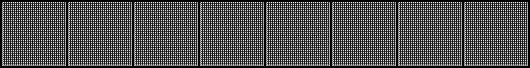

KeyboardInterrupt: ignored

In [ ]:
beta = 0.01
for epoch in range(100):
    for i, x in enumerate(loader):
        if len(x) == 2:
            x = x[0]
        x = x.cuda()
        
        mu, logvar, out = vae(x)
        rl, kl, l = loss(x, out, mu, logvar, beta)

        opt.zero_grad()
        l.backward()
        opt.step()
        if i == 0:
            vae.eval()
            data = vae.generate(8)
            grid_img = torchvision.utils.make_grid(data, nrow=8, normalize=True)
            show(grid_img)
            vae.train()

You'll also re-implement the Generator and Discriminator modules for the GAN, adopting a CNN-like architecture.

For the generator, implement a network similar to the one you used for the VAE decoder (fully connected for projection followed by 4 transposed convolutions), while for the discriminator you should use a network similar to the VAE encoder (4 conv layers with stride 2, but note that the output should be a scalar per image, not a latent vector).

In [3]:
class ConvGenerator(nn.Module):
    def __init__(self, latent_dim):
        super(ConvGenerator, self).__init__()
        self.latent_dim = latent_dim

        self.network = nn.Sequential(
            # implementation goes here
            # implementation goes here

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ELU(),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ELU(),

            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.ELU(),

            nn.ConvTranspose2d(16, 8, 4, 2, 1), 

            #NEW final convolution layers to flatten the 2nd dimension from 8 to 1 without affecting the image size 64x64
            #this is my attempted solution to unconvincing generated samples, which I think may have been caused by the OLD
            #final convolution layer below
            nn.Conv2d(8, 4, 4, 2, 1), #in, out, kernel, stride, padding
            nn.ConvTranspose2d(4, 1, 4, 2, 1)


            #OLD final convolution layer, which I believe may have been causing problems
            #nn.Conv2d(8, 1, 1, 1, 0) 


        )

        self.precoder = nn.Linear(100,128)
    
    def decode(self, input):
        
        input_length = input.size(dim=0)

        #print("input size: ", input_length)
        

        input = self.precoder(input)
        
        input.unsqueeze_(-1)
        input = input.expand(input_length,128,4)

        input.unsqueeze_(-1)
        input = input.expand(input_length,128,4,4)
        
        out = self.network(input)# implementation goes here
        

        return out

    def forward(self, n):
        z = torch.randn(n, self.latent_dim).cuda()
        samples = self.decode(z)
        return samples

In [4]:
class ConvDiscriminator(nn.Module):
    def __init__(self, latent_dim):
        super(ConvDiscriminator, self).__init__()

        self.network = nn.Sequential(
            # implementation goes here
            # implementation goes here

            nn.Conv2d(1, 16, 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.ELU(),

            nn.Conv2d(16, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ELU(),
            
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ELU(),

            nn.Conv2d(64, 128, 4, 2, 1)
        )

        self.final = nn.Linear(2048, 1)
    
    def forward(self, input):
        print("input size before discrim:", input.size())
        out = self.network(input) # implementation goes here
        print("input size after discrim:", out.size())
        out = torch.flatten(out, start_dim = 1, end_dim = -1)
        print("input size after flattening:", out.size())
        out = self.final(out)

        return out

In [5]:
generator = ConvGenerator(100).cuda()
gopt = torch.optim.Adam(generator.parameters(), lr=5e-4, betas=(0.5, 0.999))
discriminator = ConvDiscriminator(100).cuda()
dopt = torch.optim.Adam(discriminator.parameters(), lr=5e-4, betas=(0.5, 0.999))
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
def loss(out):

    l = -1*torch.log(out)
    l = torch.mean(l) #generator loss
    
    return l
 
for epoch in range(100):
    for i, x in enumerate(loader): 
        if len(x) == 2:
            x = x[0]
        x = x.cuda() #real_x
        fake_x = generator(32).cuda()

        #get discriminator values
        p = discriminator(x)
        q = discriminator(fake_x)

        #convert to probabilities with softmax
        sp = torch.exp(p)
        sq = torch.exp(q)

        q = sq/(sp + sq)

        torch.autograd.set_detect_anomaly(True)

        gopt.zero_grad()
        lG = loss(q)
        lG.backward()
        gopt.step()
        
        # Train D
        # implementation goes here

        fake_x = generator(32).cuda()

        #get discriminator values
        p = discriminator(x)
        q = discriminator(fake_x)

        #convert to probabilities with softmax
        sp = torch.exp(p)
        sq = torch.exp(q)

        q = sq/(sp + sq)

        dopt.zero_grad()
        lD = loss(1-q)
        lD.backward()
        dopt.step()
        
        #if i == 0:
            #fake = generator(8)
            #grid_img = torchvision.utils.make_grid(fake[:8], nrow=8, normalize=True)
            #show(grid_img)

input size before discrim: torch.Size([32, 1, 64, 64])
input size after discrim: torch.Size([32, 128, 4, 4])
input size after flattening: torch.Size([32, 2048])
input size before discrim: torch.Size([32, 1, 64, 64])
input size after discrim: torch.Size([32, 128, 4, 4])
input size after flattening: torch.Size([32, 2048])
input size before discrim: torch.Size([32, 1, 64, 64])
input size after discrim: torch.Size([32, 128, 4, 4])
input size after flattening: torch.Size([32, 2048])
input size before discrim: torch.Size([32, 1, 64, 64])
input size after discrim: torch.Size([32, 128, 4, 4])
input size after flattening: torch.Size([32, 2048])
input size before discrim: torch.Size([32, 1, 64, 64])
input size after discrim: torch.Size([32, 128, 4, 4])
input size after flattening: torch.Size([32, 2048])
input size before discrim: torch.Size([32, 1, 64, 64])
input size after discrim: torch.Size([32, 128, 4, 4])
input size after flattening: torch.Size([32, 2048])
input size before discrim: torch.S

KeyboardInterrupt: ignored

**<span style="color:blue">
    Compare and discuss the results you obtained with the VAE and with the GAN approach for this new dataset. Which of the two approaches was able to generate more realistic samples? Which of the two did you feel that you understood better (there is no correct answer here), and why? Mention one advantage and disadvantage of each of the two methods -- these should be precise properties about each approach, with a focus on what each method can and cannot do. Feel free to check papers, the original GAN paper might be especially helpful.
</span>**

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (BEGIN) -------------------------------------------------------------------------------
</span>**

For both models, I was not able to generate digits that looked very realistic at all. Since the code for the MNIST data is very similar to the VAE and GAN used on the toy problem, on which the VAE and GAN produced good results, this suggests that the networks or $\beta$ maybe needed more tuning, or perhaps there is an error in the CNN implementation (although I have not seen any). I tried changing the final layer of my decoder and generator in order to see if that would help, but due to time constraints I have only been able to run about 5 rows of the GAN (shown above).

With the VAE and the GAN, I was not able to achieve results that were realistic at all. For the VAE, I think this might have been possible if I spent more time tuning $\beta$, since tuning $\beta$ made a very significant difference on the toy problem. However, since the program takes a long time to run, I did not have time to do this. Below are what my results looked like before I made a modification to the final layer of the decoder/generator:

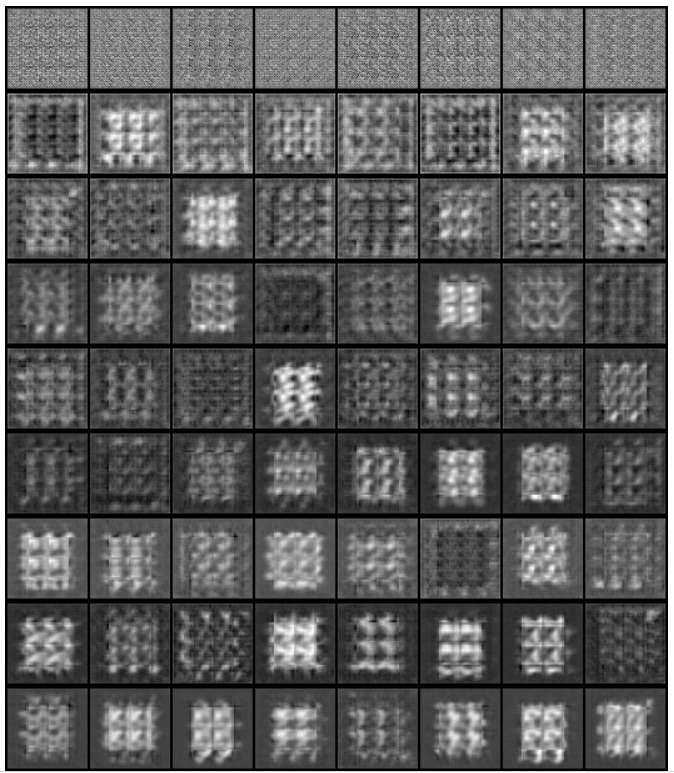


For the GAN, I also was not able to run the program completely, since it terminated prematurely due to encountering nan values at some point. It was able to produce around 12 or 15 rows of images as shown above. It is possible that tuning the generator or discriminator networks may have improved results in both the VAE and the GAN case also. GANs are supposedly known for being harder to tune than VAEs.

I felt that I was able to understand the GAN better, because the loss function is easier to think about conceptually than the VAE. The GAN training process seems simple; the loss functions simply try to maximize the probability of the discriminator believing a fake is true (i.e., that the generator can fool the discriminator) while at the same time maximizing the probability that the discriminator can recognize fakes. This conceptualization is more concrete and less abstract than the VAE formulation, which is an encoder that stochastically compresses the data into a latent variable form z. To me, the choice of a normal prior on z in the VAE also seems a bit arbitrary, and since this defines the KL part of the loss function, it is unclear to me whether or not this results in improvements rather than unnatural constraints.

For the VAE, one advantage is that they are able to learn the hidden state distributions likelihood distribution P(x|z). If the data is i.i.d. with continuous latent variables, P(z|x) can be inferred more efficiently. This allows us to perform inference on the latent variable z given the observed variable x. GANs do not have this property and are mainly used for generating data. Thus, if the latent variable formulation does have some utility to the problem or if the problem can be formulated in a natural way as having latent variables (such as words and phonemes), then we are able to learn this distribution. The ability to learn the likelihood also allows us to evaluate our VAE compared to other VAEs. The VAE also learns the mean and variance of the normal distribution of the latent variable z, while for the GAN the distribution of the latent variable z is predefined beforehand. On the other hand, a disadvantage of VAEs is that to the best of my knowledge, they do not have the same universitality assumption as GANs. VAEs also require tuning of the $\beta$ parameter, while GANs do not. In our case, not choosing $\beta$ properly caused difficulties in being able to generate good fakes, and it was not immediately obvious how to choose $\beta$.

The GAN was able to generate much better fakes, at least with the toy example. They are also known for being able to create much better fakes than VAEs. This may be a result of the following property of GANs. Namely, that optimization reaches a global minimum only when this distribution is equal to the actual distribution of the data, which the distribution defined by the generator can achieve. This implies that if we are able to train the GAN properly, and we have the correct architecture, we can create fakes of any data as though it came from the population. However, since GANs do not exactly optimize the likelihood of the data, they may generate something that looks real, but does not actually coincide with high likelihood of the true distribution of the population. On the other hand, VAEs aim to optimize likelihood. GANs also do not allow us to estimate a log likelihood of the data, so we cannot compare GANs in this way as we can with VAEs, except by how real the generated samples look.

References: Original GAN paper, others

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (END) -------------------------------------------------------------------------------
</span>**